## Boston Listing Data Cleaning

In [50]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
%matplotlib inline

In [51]:
pd.set_option("display.max.columns", None)
pd.set_option('min_rows', 10)
# pd.options.display.max_rows

### 1.1 Load the data

In [52]:
# read boston listing data, ignore 'access','interaction','house_rules' columns, set 'id' as index
df = pd.read_csv('boston\listings.csv', sep=',', index_col='id', 
                 usecols = lambda column : column not in ['access','interaction','house_rules'],
                 parse_dates=['last_scraped', 'host_since'], na_filter=True)

In [53]:
df.head(1)

,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
12147973,https://www.airbnb.com/rooms/12147973,20160906204935,2016-09-07,Sunny Bungalow in the City,"Cozy, sunny, family home. Master bedroom high...",The house has an open and cozy feel at the sam...,"Cozy, sunny, family home. Master bedroom high...",none,"Roslindale is quiet, convenient and friendly. ...",NaN,"The bus stop is 2 blocks away, and frequent. B...",https://a2.muscache.com/im/pictures/c0842db1-e...,https://a2.muscache.com/im/pictures/c0842db1-e...,https://a2.muscache.com/im/pictures/c0842db1-e...,https://a2.muscache.com/im/pictures/c0842db1-e...,31303940,https://www.airbnb.com/users/show/31303940,Virginia,2015-04-15,"Boston, Massachusetts, United States",We are country and city connecting in our deck...,NaN,NaN,NaN,f,https://a2.muscache.com/im/pictures/5936fef0-b...,https://a2.muscache.com/im/pictures/5936fef0-b...,Roslindale,1,1,"['email', 'phone', 'facebook', 'reviews']",t,f,"Birch Street, Boston, MA 02131, United States",Roslindale,Roslindale,NaN,Boston,MA,02131,Boston,"Boston, MA",US,United States,42.282619,-71.133068,t,House,Entire home/apt,4,1.5,2.0,3.0,Real Bed,"{TV,""Wireless Internet"",Kitchen,""Free Parking ...",NaN,$250.00,NaN,NaN,NaN,$35.00,1,$0.00,2,1125,2 weeks ago,NaN,0,0,0,0,2016-09-06,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,NaN,NaN,f,moderate,f,f,1,NaN


In [54]:
df.shape

(3585, 91)

### 1.2 Drop unnecessary columns
feat_info.csv was manually created and contains info about necessary property/actions to each column, such as id, numeric, categorical, location, drop, convert to numeric and convert to date etc.
It is worth mentioning why certain columns were dropped.
1. host_total_listings_count/calculated_host_listings_count: high correlation with host_listings_count
2. host_verifications: use host_identity_verified
3. zipcode: use neighbourhood_cleansed 
4. weekly_price/monthly_price: somewhat related to dependent variable or target daily 'price'. From an AirBnB home landlord's perspective, he/she is mostly like to set the daily 'price' first, before setting weekly_price/monthly_price charge.
5. number_of_reviews: use reviews_per_month

In [55]:
feat_info = pd.read_csv('feat_info.csv', sep=',')

# drop unnecessary columns
column_dropped_1 = feat_info[feat_info.action == 'drop']['name'].to_list()
df.drop(columns = column_dropped_1, axis=1, inplace = True)
df.shape

(3585, 43)

### 1.3 Convert data
'extra_people' is somewhat related to dependent variable or target 'price'. From a home landlord's perspective, he/she is mostly like to set the price first, before setting 'extra_people' charge. This means 'extra_people' can be ignored. However, 'extra_people' does affect the 'price' to some extend. To keep this effect, 0/1 dummy was used. The same applies to security_deposit' and 'cleaning_fee'.

In [56]:
# object to numeric
df['host_acceptance_rate'] = df['host_acceptance_rate'].str.replace('%', '').astype(float)/100
df['host_response_rate'] = df['host_response_rate'].str.replace('%', '').astype(float)/100
df['price'] = df['price'].replace('[$,]', '', regex=True).astype(float)
df['extra_people'] = df['extra_people'].replace('[$,]', '', regex=True).astype(float)

# convert to 0/1
df['extra_people'] = df['extra_people'].apply(lambda x: 1 if x>0 else 0)
# https://stackoverflow.com/questions/37543647/how-to-replace-all-non-nan-entries-of-a-dataframe-with-1-and-all-nan-with-0
df[['security_deposit', 'cleaning_fee']] = df[['security_deposit', 'cleaning_fee']].notnull().astype('int')

# calculate host days
df['host_days'] = (df['last_scraped'] - df['host_since']).dt.days

# convert calendar_updated to numeric days
calendar_updated_dict = {'today': 0, '2 weeks ago': 14, 'a week ago': 7, '3 weeks ago': 21, '2 months ago': 60, 'yesterday': 1, '4 weeks ago': 28, '3 months ago': 90, '4 days ago': 4, '5 weeks ago': 35, '3 days ago': 3, '5 days ago': 5, '4 months ago': 120, '6 weeks ago': 42, '2 days ago': 2, '5 months ago': 150, '7 weeks ago': 49, '7 months ago': 210, '6 days ago': 6, '1 week ago': 7, '6 months ago': 180, '8 months ago': 240, '10 months ago': 300, '9 months ago': 270, 'never': -1, '11 months ago': 330, '13 months ago': 390, '14 months ago': 420, '12 months ago': 360, '17 months ago': 510, '15 months ago': 450, '16 months ago': 480, '22 months ago': 660, '18 months ago': 540, '25 months ago': 750, '30 months ago': 900, '20 months ago': 600, '23 months ago': 690} 
df.calendar_updated.replace(calendar_updated_dict, inplace=True)
df['calendar_updated'] = np.where(df['calendar_updated'] <0, df['host_days'], df['calendar_updated']).astype(int)
df.drop(columns=['last_scraped','host_since'], axis=1, inplace=True)

### 1.4 Drop outliers
From the histogram of our target variable 'price', it is easy to observe that 'price' has a wide range of values. 
The extreme values (outliers) may affect the predicting power of the final model. Thus, some rows with extreme values of 'price' will be deleted. 
From the plot, it seems $700 is a good cutoff point. A total of 21 rows were deleted.

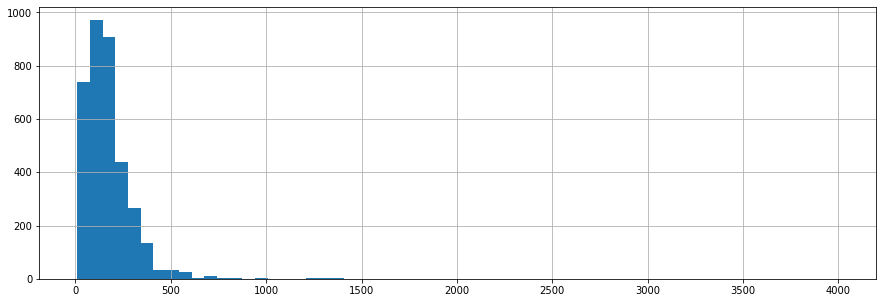

In [57]:
df.price.hist(figsize=(15, 5), bins=60)

In [58]:
df = df[df.price < 700]
df.shape

(3560, 42)

### 1.5 Drop rows with >30% data missing

Text(0.5, 0, '% percentage of missing columns for each row')

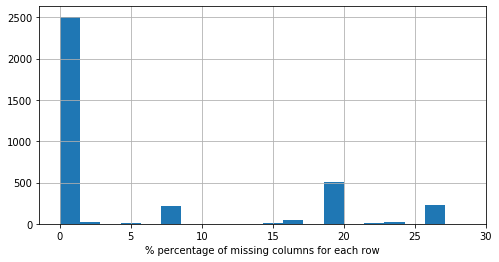

In [59]:
# missing data in each row
missing_row_ct = df.isnull().sum(axis = 1)
missing_row_ct.sort_values(ascending = False, inplace=True)
missing_row_pct = missing_row_ct/(df.shape[1]) * 100

# percentage of missing data in each row
missing_row_pct.hist(figsize=(8, 4), bins=20)
plt.xlabel('% percentage of missing columns for each row')

In [60]:
# delete rows with 30% more value missing, 0 rows deleted
df = df[df.isnull().sum(axis=1) < df.shape[1] * 0.3]
df.shape

(3560, 42)

### 1.6 Impute nulls in columns
The majority of columns have no missing values. For those having missing values, no single column has missing value than 25%. We will impute the nulls with mean or mode values. 

Text(0, 0.5, 'missing %')

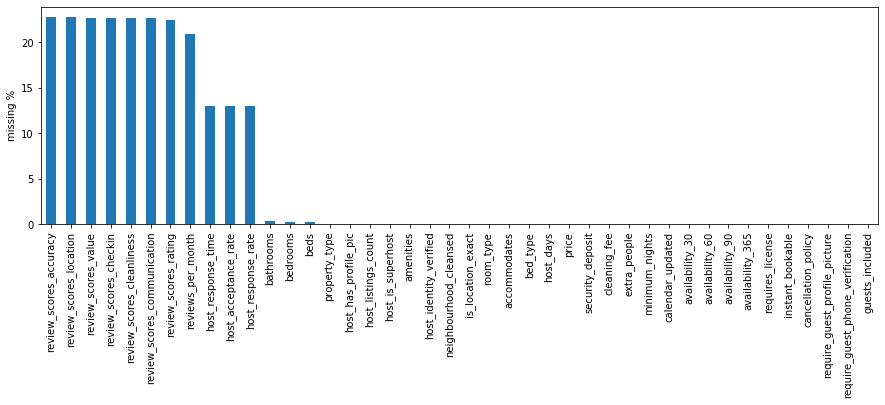

In [61]:
# missing data in each column
missing_ct = df.isnull().sum()
missing_ct.sort_values(ascending = False, inplace=True)
missing_pct = missing_ct/(df.shape[0]) * 100

# percentage of missing data in each column.
missing_pct.plot.bar(figsize=(15, 4))
plt.ylabel('missing %')

In [62]:
# fillna with mode for categorical columns, and the numeric columns that only take integer/fixed values
for col in ['host_response_time','property_type','bathrooms','bedrooms', 'beds']:
    df[col].fillna(df[col].mode().iloc[0], inplace=True)

In [63]:
# fillna with mean for numeric columns
df.fillna(df.mean(), inplace=True)

In [64]:
# double check there is no null values
df.isnull().mean()[df.isnull().mean() > 0].sort_values(ascending=False)

Series([], dtype: float64)

### 1.7 Convert 'amenities' to individual amenity

In [65]:
df['amenities'].replace(to_replace='[\{\}\"]', value='', regex=True, inplace=True)
amenities_dummy = df['amenities'].str.get_dummies(sep=',').add_prefix('amenity_')

# concatenate all individual amenities column with the full dataset
df = pd.concat([df, amenities_dummy], axis=1, sort=False)
df.drop(columns=['amenities'], inplace=True, axis=1)

In [66]:
# create a list of object columns
cols_cat = df.select_dtypes(include=[object]).columns.to_list()

### 1.8 One-hot encoding of categorical fetures

In [67]:
df = pd.get_dummies(data=df, prefix=cols_cat, prefix_sep='_', columns=cols_cat, drop_first=True)

### 1.9 Final review of the processed data

In [68]:
df.head()

,host_response_rate,host_acceptance_rate,host_listings_count,accommodates,bathrooms,bedrooms,beds,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,calendar_updated,availability_30,availability_60,availability_90,availability_365,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month,host_days,amenity_24-Hour Check-in,amenity_Air Conditioning,amenity_Breakfast,amenity_Buzzer/Wireless Intercom,amenity_Cable TV,amenity_Carbon Monoxide Detector,amenity_Cat(s),amenity_Dog(s),amenity_Doorman,amenity_Dryer,amenity_Elevator in Building,amenity_Essentials,amenity_Family/Kid Friendly,amenity_Fire Extinguisher,amenity_First Aid Kit,amenity_Free Parking on Premises,amenity_Free Parking on Street,amenity_Gym,amenity_Hair Dryer,amenity_Hangers,amenity_Heating,amenity_Hot Tub,amenity_Indoor Fireplace,amenity_Internet,amenity_Iron,amenity_Kitchen,amenity_Laptop Friendly Workspace,amenity_Lock on Bedroom Door,amenity_Other pet(s),amenity_Paid Parking Off Premises,amenity_Pets Allowed,amenity_Pets live on this property,amenity_Pool,amenity_Safety Card,amenity_Shampoo,amenity_Smoke Detector,amenity_Smoking Allowed,amenity_Suitable for Events,amenity_TV,amenity_Washer,amenity_Washer / Dryer,amenity_Wheelchair Accessible,amenity_Wireless Internet,amenity_translation missing: en.hosting_amenity_49,amenity_translation missing: en.hosting_amenity_50,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour,host_is_superhost_t,host_has_profile_pic_t,host_identity_verified_t,neighbourhood_cleansed_Back Bay,neighbourhood_cleansed_Bay Village,neighbourhood_cleansed_Beacon Hill,neighbourhood_cleansed_Brighton,neighbourhood_cleansed_Charlestown,neighbourhood_cleansed_Chinatown,neighbourhood_cleansed_Dorchester,neighbourhood_cleansed_Downtown,neighbourhood_cleansed_East Boston,neighbourhood_cleansed_Fenway,neighbourhood_cleansed_Hyde Park,neighbourhood_cleansed_Jamaica Plain,neighbourhood_cleansed_Leather District,neighbourhood_cleansed_Longwood Medical Area,neighbourhood_cleansed_Mattapan,neighbourhood_cleansed_Mission Hill,neighbourhood_cleansed_North End,neighbourhood_cleansed_Roslindale,neighbourhood_cleansed_Roxbury,neighbourhood_cleansed_South Boston,neighbourhood_cleansed_South Boston Waterfront,neighbourhood_cleansed_South End,neighbourhood_cleansed_West End,neighbourhood_cleansed_West Roxbury,is_location_exact_t,property_type_Bed & Breakfast,property_type_Boat,property_type_Camper/RV,property_type_Condominium,property_type_Dorm,property_type_Entire Floor,property_type_Guesthouse,property_type_House,property_type_Loft,property_type_Other,property_type_Townhouse,property_type_Villa,room_type_Private room,room_type_Shared room,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,instant_bookable_t,cancellation_policy_moderate,cancellation_policy_strict,cancellation_policy_super_strict_30,require_guest_profile_picture_t,require_guest_phone_verification_t
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
12147973,0.950284,0.841404,1,4,1.5,2.0,3.0,250.0,0,1,1,0,2,14,0,0,0,0,91.888406,9.429818,9.255898,9.645114,9.645372,9.412214,9.166788,1.976816,511,0,0,0,0,0,0,0,1,0,1,0,1,1,1,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,1,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
3075044,1.000000,1.000000,1,2,1.0,1.0,1.0,65.0,1,1,0,0,2,7,26,54,84,359,94.000000,10.000000,9.000000,10.000000,10.000000,9.000000,9.000000,1.300000,1553,0,1,0,0,0,1,0,1,0,1,0,1,1,1,0,0,0,0,1,1,1,0,0,1,1,1,0,1,0,0,1,1,0,0,1,1,0,0,1,1,0,0,1,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,1,0,0,0,0
6976,1.000000,0.880000,1,2,1.0,1.0,1.0,65.0,0,0,1,1,3,5,19,46,61,319

In [69]:
df.shape

(3560, 127)

### 1.10 Save the processed data to local file

In [70]:
df.to_csv('results\df_listings_boston.csv')